In [1]:
# lib's base 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# lib's para modelagem
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor


import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
#pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 1. pré-modelagem

In [2]:
df_modelagem = pd.read_csv('../dados/outputs/st_variaveis_modelagem.csv')
df_modelagem.set_index('DATA', inplace=True)
df_modelagem.head()

,VOL_TOTAL_NEGOCIADO_ESTAC,IBOVESPA_GOOGLE_ESTAC,IBOV_TWITTER_ESTAC
DATA,,,
2021-01-05,1.094933e+09,77,128
2021-01-06,1.049862e+09,75,104
2021-01-07,1.081833e+09,79,182
2021-01-08,1.427557e+09,72,224
2021-01-11,1.088389e+09,63,79


In [3]:
# separação de features e resposta
X = df_modelagem.iloc[:,1:]
y = df_modelagem.VOL_TOTAL_NEGOCIADO_ESTAC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

In [4]:
# função de validação cruzada
n_folds = 5

def rmse_cv(modelo):
    kf = KFold(n_folds, shuffle = True, random_state = 42).get_n_splits(X_train)
    return cross_val_score(modelo, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)

## 2. modelagem

### 2.1. regressão linear múltipla

In [5]:
# criar regressão
LR = LinearRegression()

# fazer o ajuste aos dados de treino
LR.fit(X_train, y_train) 

# previsão para dados de treino e de teste
y_train_LR = LR.predict(X_train)
y_test_LR = LR.predict(X_test)

# df com métricas de treino e teste
resultados_lr = pd.DataFrame({'Algoritmo':['Linear'],
            'MSE Treino': [mean_squared_error(y_train, y_train_LR)],
            'MSE Teste': [mean_squared_error(y_test, y_test_LR)],
            'MAPE Treino': [mean_absolute_percentage_error(y_train, y_train_LR)],                  
            'MAPE Teste': [mean_absolute_percentage_error(y_test, y_test_LR)],
            'R2 Treino': [r2_score(y_train, y_train_LR)],
            'R2 Teste': [r2_score(y_test, y_test_LR)]})

resultados_lr

,Algoritmo,MSE Treino,MSE Teste,MAPE Treino,MAPE Teste,R2 Treino,R2 Teste
0,Linear,6.766631e+16,6.107770e+16,0.211096,0.199416,0.490164,0.642729


In [6]:
# unificar df's de real e predição
rl_train = pd.DataFrame({'REAL':y_train, 'PREDICT':y_train_LR})
rl_test = pd.DataFrame({'REAL':y_test, 'PREDICT':y_test_LR})

rl_valores = pd.concat([rl_train, rl_test], axis = 0)
rl_valores.reset_index(drop = True, inplace = True)

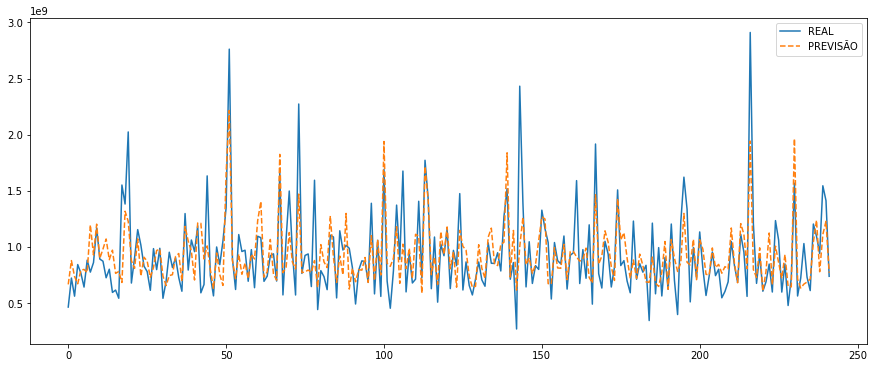

In [7]:
plt.figure(figsize = (15, 6))

plt.plot(rl_valores['REAL'], label = 'REAL')
plt.plot(rl_valores['PREDICT'], '--', label = 'PREVISÃO')

plt.legend(loc = 'best')
plt.show()

### 2.2. regressão ridge

In [8]:
# definir melhor valor de regularização
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 25, 50, 75, 100] 
cv_ridge = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

# alpha que resulta no menor RMSE
cv_ridge = pd.DataFrame(cv_ridge, columns = ['RMSE'])
alphas = pd.DataFrame(alphas, columns = ['ALPHA'])
alpha_rmse = pd.concat([cv_ridge, alphas], axis = 1)
alpha_rmse.sort_values(by = 'RMSE')

,RMSE,ALPHA
0,6.835694e+16,0.05
1,6.835694e+16,0.10
2,6.835695e+16,0.30
3,6.835700e+16,1.00
4,6.835714e+16,3.00
5,6.835728e+16,5.00
6,6.835764e+16,10.00
7,6.835873e+16,25.00
8,6.836067e+16,50.00
9,6.836274e+16,75.00


In [9]:
# criar regressão
RR = Ridge(alpha = 0.05) 

# fazer o ajuste aos dados de treino
RR.fit(X_train, y_train) 

# previsão para dados de treino e de teste
y_train_RR = RR.predict(X_train)
y_test_RR = RR.predict(X_test)

# df com métricas de treino e teste
resultados_ridge = pd.DataFrame({'Algoritmo':['Ridge'],
            'MSE Treino': [mean_squared_error(y_train, y_train_RR)],
            'MSE Teste': [mean_squared_error(y_test, y_test_RR)],
            'MAPE Treino': [mean_absolute_percentage_error(y_train, y_train_RR)],                  
            'MAPE Teste': [mean_absolute_percentage_error(y_test, y_test_RR)],
            'R2 Treino': [r2_score(y_train, y_train_RR)],
            'R2 Teste': [r2_score(y_test, y_test_RR)]})

resultados_ridge

,Algoritmo,MSE Treino,MSE Teste,MAPE Treino,MAPE Teste,R2 Treino,R2 Teste
0,Ridge,6.766631e+16,6.107774e+16,0.211096,0.199416,0.490164,0.642729


In [10]:
# unificar df's de real e predição
rr_train = pd.DataFrame({'REAL':y_train, 'PREDICT':y_train_RR})
rr_test = pd.DataFrame({'REAL':y_test, 'PREDICT':y_test_RR})

rr_valores = pd.concat([rr_train, rr_test], axis = 0)
rr_valores.reset_index(drop = True, inplace = True)

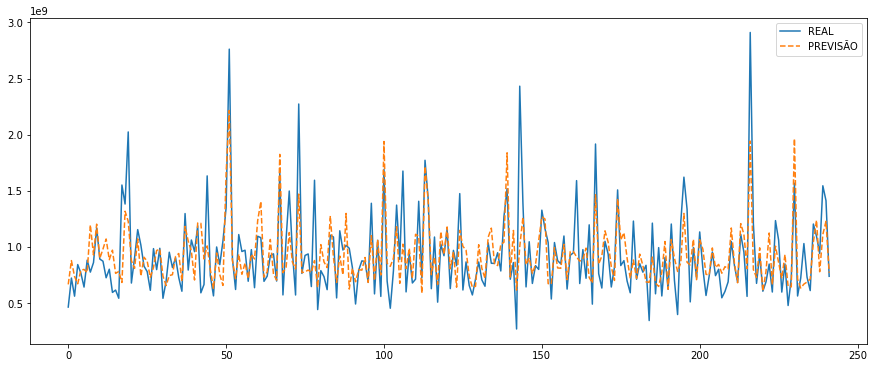

In [11]:
plt.figure(figsize = (15, 6))

plt.plot(rr_valores['REAL'], label = 'REAL')
plt.plot(rr_valores['PREDICT'], '--', label = 'PREVISÃO')

plt.legend(loc = 'best')
plt.show()

### 2.3. regressão lasso

In [12]:
# definir melhor valor de regularização
alphas = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 1] 
cv_lasso = [-rmse_cv(Lasso(alpha = alpha, max_iter = 2000)).mean() for alpha in alphas]

# alpha que resulta no menor RMSE
cv_lasso = pd.DataFrame(cv_lasso, columns = ['RMSE'])
alphas = pd.DataFrame(alphas, columns = ['ALPHA'])
alpha_rmse = pd.concat([cv_lasso, alphas], axis = 1)
alpha_rmse.sort_values(by = 'RMSE')

,RMSE,ALPHA
5,6.835693e+16,0.1000
4,6.835693e+16,0.0500
3,6.835693e+16,0.0100
2,6.835693e+16,0.0050
1,6.835693e+16,0.0010
0,6.835693e+16,0.0001
6,6.835693e+16,0.3000
7,6.835693e+16,1.0000


In [13]:
# criar regressão
lasso = Lasso(alpha = 0.1) 

# fazer o ajuste aos dados de treino
lasso.fit(X_train, y_train) 

# previsão para dados de treino e de teste
y_train_lasso = lasso.predict(X_train)
y_test_lasso = lasso.predict(X_test)

# df com métricas de treino e teste
resultados_lasso = pd.DataFrame({'Algoritmo':['Lasso'],
            'MSE Treino': [mean_squared_error(y_train, y_train_lasso)],
            'MSE Teste': [mean_squared_error(y_test, y_test_lasso)],
            'MAPE Treino': [mean_absolute_percentage_error(y_train, y_train_lasso)],                  
            'MAPE Teste': [mean_absolute_percentage_error(y_test, y_test_lasso)],
            'R2 Treino': [r2_score(y_train, y_train_lasso)],
            'R2 Teste': [r2_score(y_test, y_test_lasso)]})

resultados_lasso

,Algoritmo,MSE Treino,MSE Teste,MAPE Treino,MAPE Teste,R2 Treino,R2 Teste
0,Lasso,6.766631e+16,6.107770e+16,0.211096,0.199416,0.490164,0.642729


a regressão lasso selecionou 2 variáveis e eliminou 0


Text(0.5, 1.0, 'Coeficientes no Modelo')

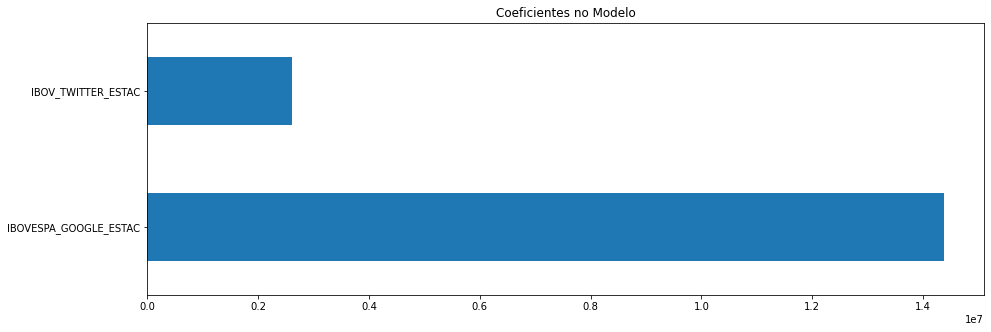

In [14]:
# features selecionadas e coeficientes
features = list(X.columns)
coef = pd.Series(lasso.coef_, index = features)
print("a regressão lasso selecionou " + str(sum(coef != 0)) + " variáveis e eliminou " +  str(sum(coef == 0)))

coef.plot(kind = "barh", figsize = (15, 5))
plt.title("Coeficientes no Modelo")

In [15]:
# unificar df's de real e predição
lasso_train = pd.DataFrame({'REAL':y_train, 'PREDICT':y_train_lasso})
lasso_test = pd.DataFrame({'REAL':y_test, 'PREDICT':y_test_lasso})

lasso_valores = pd.concat([lasso_train, lasso_test], axis = 0)
lasso_valores.reset_index(drop = True, inplace = True)

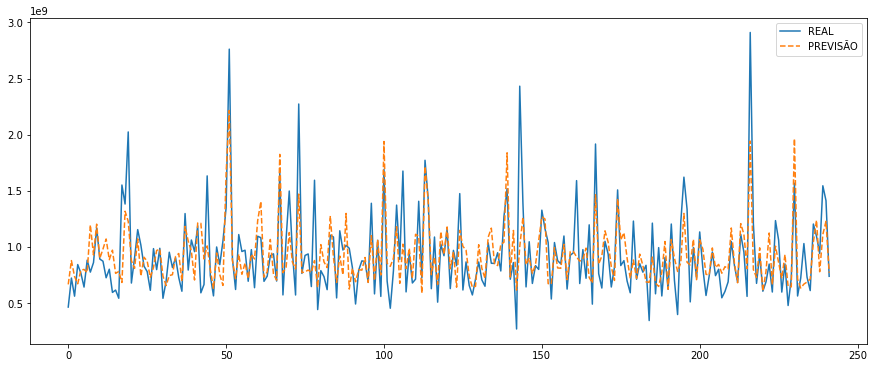

In [16]:
plt.figure(figsize = (15, 6))

plt.plot(lasso_valores['REAL'], label = 'REAL')
plt.plot(lasso_valores['PREDICT'], '--', label = 'PREVISÃO')

plt.legend(loc = 'best')
plt.show()

### 2.4. regressão random forest

In [17]:
# selecionar melhores hiperparâmetros
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap}

# tunning dos hiperparâmetros
rf = RandomForestRegressor(random_state = 42)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose = 2, random_state = 42, n_jobs = -1)

# fazer o ajuste aos dados de treino
rf_random.fit(X_train, y_train)

print(rf_random.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}


In [18]:
# criar regressão com hiperparâmetros selecionados
rf = RandomForestRegressor(n_estimators = 200, min_samples_split = 10, min_samples_leaf = 2, max_features = 'sqrt', 
                                   max_depth = 50, bootstrap = True, criterion = 'mse', random_state = 42, verbose = 0)

# fazer o ajuste aos dados de treino
rf.fit(X_train, y_train) 

# previsão para dados de treino e de teste
y_train_rf = rf.predict(X_train)
y_test_rf = rf.predict(X_test)

# df com métricas de treino e teste
resultados_rf = pd.DataFrame({'Algoritmo':['Random Forest'],
            'MSE Treino': [mean_squared_error(y_train, y_train_rf)],
            'MSE Teste': [mean_squared_error(y_test, y_test_rf)],                 
            'MAPE Treino': [mean_absolute_percentage_error(y_train, y_train_rf)],                  
            'MAPE Teste': [mean_absolute_percentage_error(y_test, y_test_rf)],
            'R2 Treino': [r2_score(y_train, y_train_rf)],
            'R2 Teste': [r2_score(y_test, y_test_rf)]})

resultados_rf

,Algoritmo,MSE Treino,MSE Teste,MAPE Treino,MAPE Teste,R2 Treino,R2 Teste
0,Random Forest,5.026192e+16,6.850056e+16,0.182331,0.198078,0.621299,0.59931


In [19]:
# unificar df's de real e predição
rf_train = pd.DataFrame({'REAL':y_train, 'PREDICT':y_train_rf})
rf_test = pd.DataFrame({'REAL':y_test, 'PREDICT':y_test_rf})

rf_valores = pd.concat([rf_train, rf_test], axis = 0)
rf_valores.reset_index(drop = True, inplace = True)

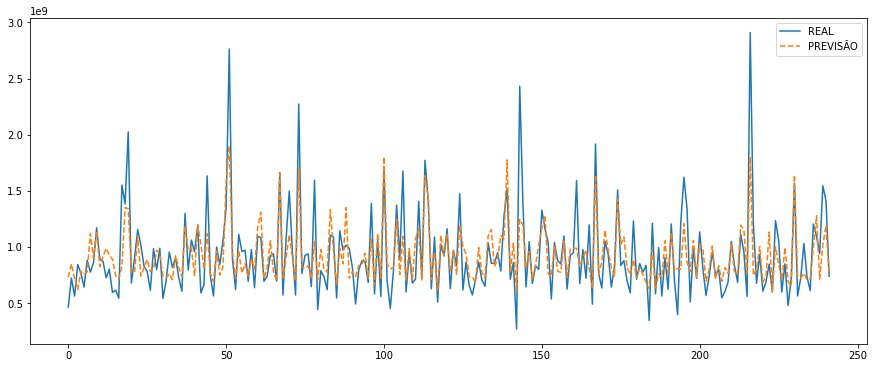

In [20]:
plt.figure(figsize = (15, 6))

plt.plot(rf_valores['REAL'], label = 'REAL')
plt.plot(rf_valores['PREDICT'], '--', label = 'PREVISÃO')

plt.legend(loc = 'best')
plt.show()

In [21]:
# importância de cada variável
var_imp = pd.DataFrame({'Variável':X.columns, 'Importância':rf.fit(X_train, y_train).feature_importances_})
var_imp.sort_values(by = 'Importância', ascending = False, inplace = True)
var_imp

,Variável,Importância
1,IBOV_TWITTER_ESTAC,0.514731
0,IBOVESPA_GOOGLE_ESTAC,0.485269


### 2.5. modelo fuzzy

### 2.6. modelo ARIMA

## 3. comparativo

In [22]:
pd.concat([resultados_lr, resultados_ridge, resultados_lasso, resultados_rf], axis = 0, ignore_index = True)

,Algoritmo,MSE Treino,MSE Teste,MAPE Treino,MAPE Teste,R2 Treino,R2 Teste
0,Linear,6.766631e+16,6.107770e+16,0.211096,0.199416,0.490164,0.642729
1,Ridge,6.766631e+16,6.107774e+16,0.211096,0.199416,0.490164,0.642729
2,Lasso,6.766631e+16,6.107770e+16,0.211096,0.199416,0.490164,0.642729
3,Random Forest,5.026192e+16,6.850056e+16,0.182331,0.198078,0.621299,0.599310


<AxesSubplot:title={'center':'Random Forest'}>

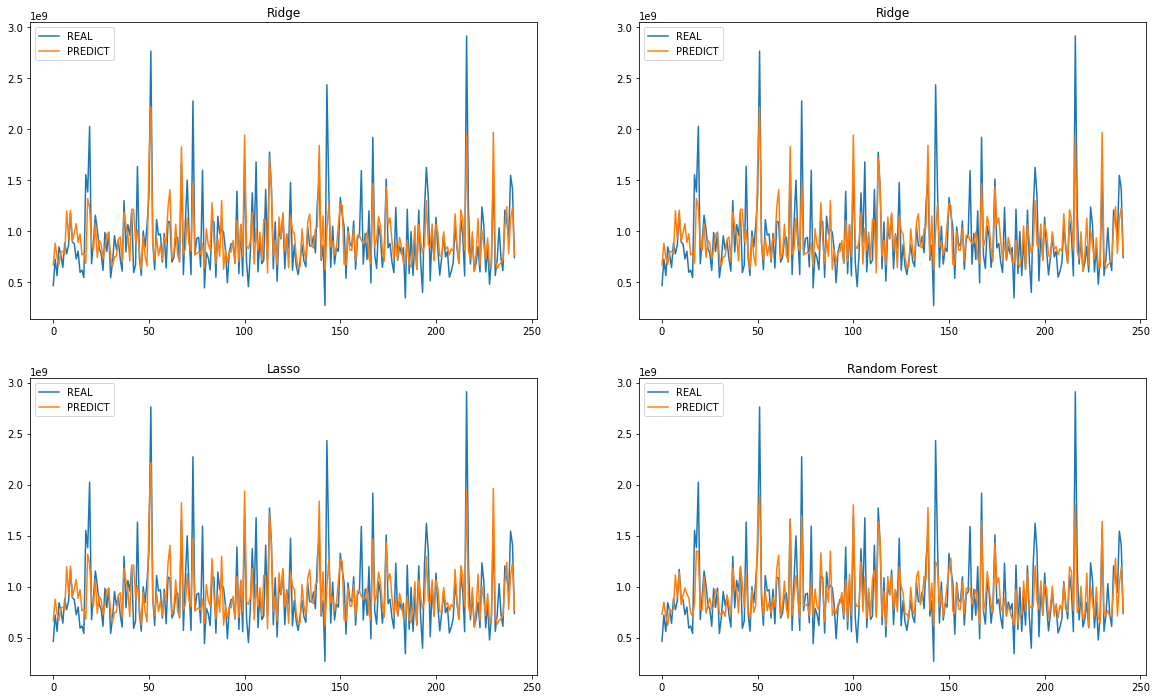

In [23]:
fig, axes = plt.subplots(2, 2, figsize = (20, 12))

rl_valores.plot(ax = axes[0, 0], title = 'Ridge')
rr_valores.plot(ax = axes[0, 1], title = 'Ridge')
lasso_valores.plot(ax = axes[1, 0], title = 'Lasso')
rf_valores.plot(ax = axes[1, 1], title = 'Random Forest')

## 4. consolidação dos modelos

In [24]:
# classificador
clf = VotingRegressor(estimators=[('lr', LR), ('ridge', RR), ('lasso', lasso), ('rf', rf)])

# Treinar o classificador de votação
clf.fit(X_train, y_train)

# previsão para dados de treino e de teste
y_train_clf = clf.predict(X_train)
y_test_clf = clf.predict(X_test)

# calcular o R² para dados de treino e teste
r2_train = r2_score(y_train, y_train_clf)
r2_test = r2_score(y_test, y_test_clf)

# resultados
print("R² para dados de treino: {:.4f}".format(r2_train))
print("R² para dados de teste: {:.4f}".format(r2_test))

R² para dados de treino: 0.5301
R² para dados de teste: 0.6377


In [25]:
# unificar df's de real e predição
classificador_train = pd.DataFrame({'REAL':y_train, 'PREDICT':y_train_clf})
classificador_test = pd.DataFrame({'REAL':y_test, 'PREDICT':y_test_clf})

classificador_valores = pd.concat([classificador_train, classificador_test], axis = 0)
classificador_valores.reset_index(drop = True, inplace = True)

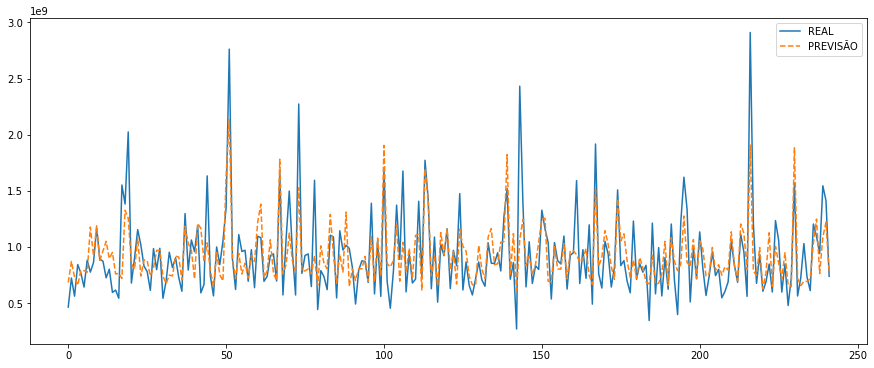

In [26]:
plt.figure(figsize = (15, 6))

plt.plot(classificador_valores['REAL'], label = 'REAL')
plt.plot(classificador_valores['PREDICT'], '--', label = 'PREVISÃO')

plt.legend(loc = 'best')
plt.show()